In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### Задача:
- научиться считывать признаки;
- получить baseline классификации по готовым признакам с помощью логистической регресии; 
- построить распределения вероятностей;

In [2]:
!ls ../data/featureMatrix/

YaoXuFeaturesLeft   YaoXuFilters       YuliaFeaturesRight
YaoXuFeaturesRight  YuliaFeaturesLeft  YuliaFilters


In [3]:
fr_Yao = pd.read_csv('../data/featureMatrix/YaoXuFeaturesRight',header=None)
fl_Yao = pd.read_csv('../data/featureMatrix/YaoXuFeaturesLeft',header=None)

fl_Yulia = pd.read_csv('../data/featureMatrix/YuliaFeaturesLeft',header=None)
fr_Yulia = pd.read_csv('../data/featureMatrix/YuliaFeaturesRight',header=None)

print "Размерность матрицы признаков для правой руки",fr_Yao.shape,fr_Yulia.shape
print "Размерность матрицы признаков для левой руки",fl_Yao.shape,fl_Yulia.shape

Размерность матрицы признаков для правой руки (60, 6) (60, 6)
Размерность матрицы признаков для левой руки (60, 6) (60, 6)


Пока попробую только с данными Юлии обработать. Дальше, может быть, и те и другие

In [4]:
X = np.vstack((fr_Yao.values,fr_Yulia.values,fl_Yao, fl_Yulia.values)) #stack to full object-features matrix

In [5]:
labels = np.hstack((np.ones(fr_Yao.shape[0]+fr_Yulia.shape[0]),np.zeros(fl_Yao.shape[0]+fl_Yulia.shape[0])))

1 - правая рука
0 - левая рука

In [6]:
import seaborn as sns
sns.set_style('whitegrid')

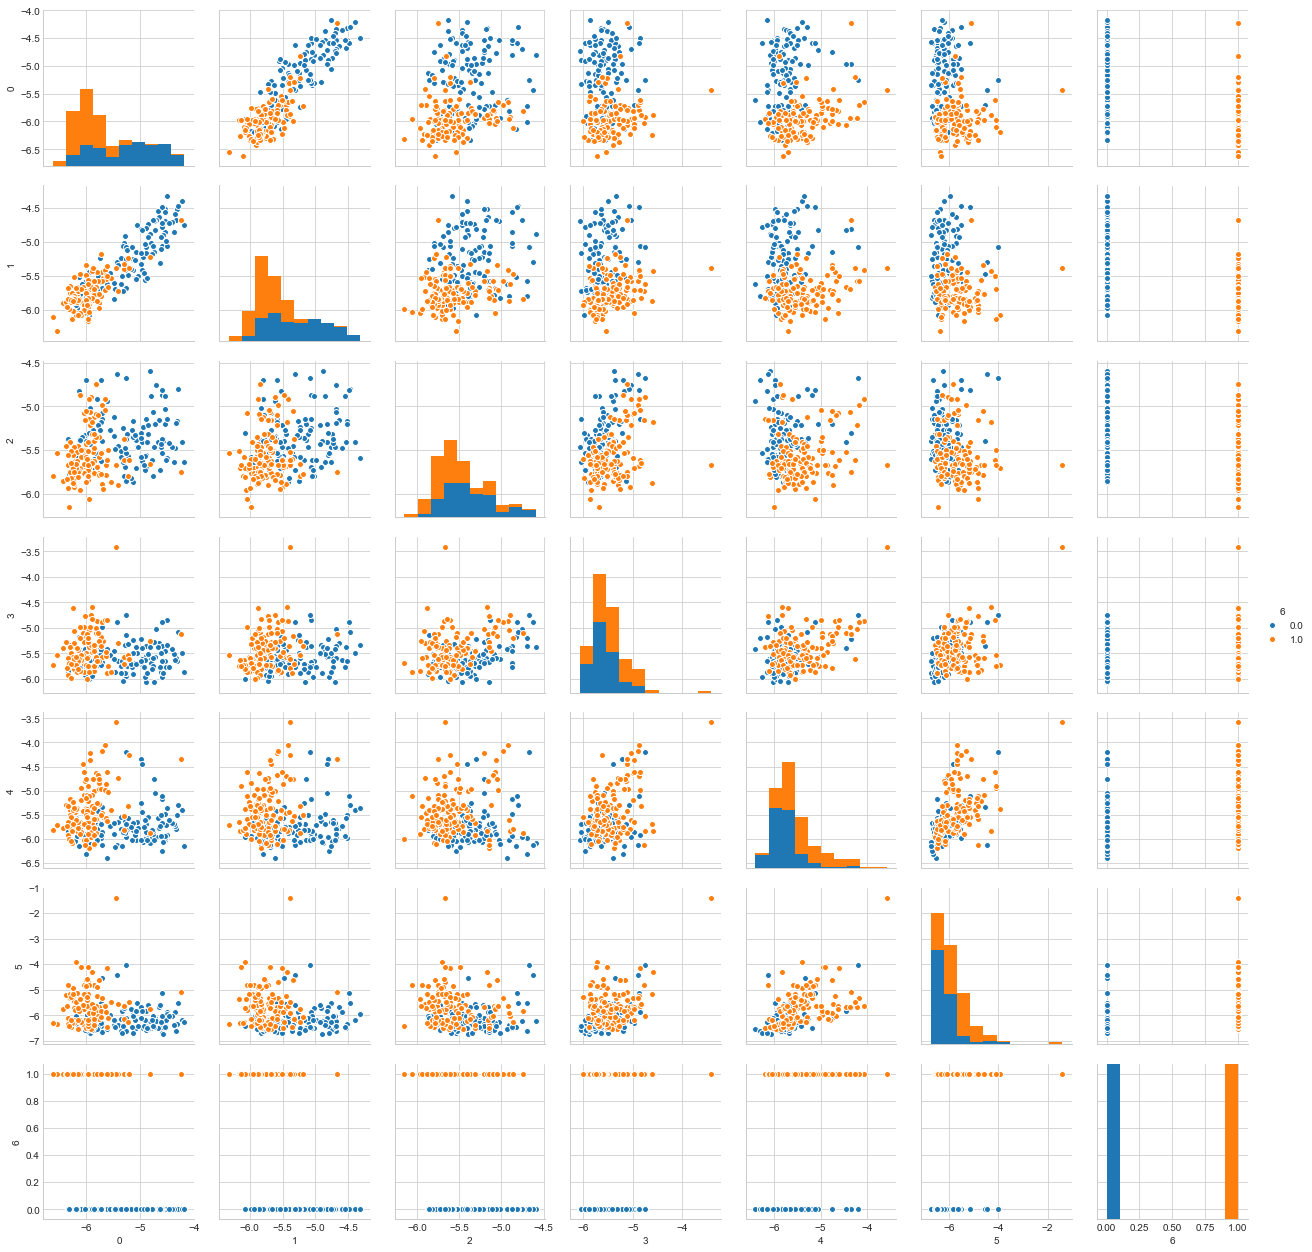

In [7]:
sns.pairplot(pd.DataFrame(np.hstack((X,labels.reshape(-1,1)))),hue=6)

Посмотрим, большое ли количество признаков действительно является значимым

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA()

In [11]:
pca.fit(X=X,y=labels)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

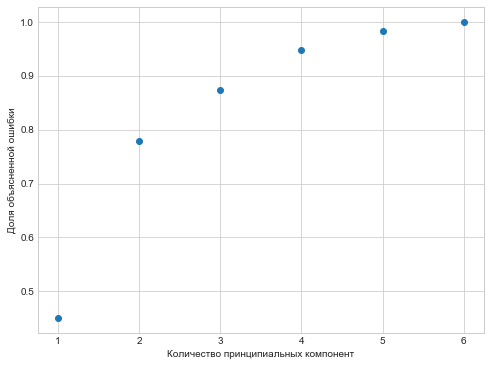

In [12]:
plt.figure(figsize=(8,6))

plt.plot(range(1,X.shape[1]+1),pca.explained_variance_ratio_.cumsum(),'o')
plt.ylabel(u'Доля объясненной ошибки')
plt.xlabel(u'Количество принципиальных компонент')

В целом, как видно, значимыми являются все признаки, но 3 из них должны объяснять 90% вариабельности данных.

Попробуем натренировать логистическую регресиию

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Перемешиваем и разбиваем выборку на тренировочную и тестовую

In [14]:
random_state=42

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,labels,test_size=0.3,random_state=random_state)

Пробуем подобрать коэффициент регуляризации (1/C) и функцию потерь (L2 или L1)

In [16]:
lr = LogisticRegression(n_jobs=-1)
search_params = {
    'penalty':['l2','l1'],
    'C':np.logspace(-3,3,num=7)
}
cv = 5
grid_estimator = GridSearchCV(estimator=lr,param_grid=search_params,cv=5,scoring='accuracy',n_jobs=1)

In [17]:
grid_estimator.fit(X_train,y_train)

/home/boris/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
def classification_report(grid_estimator,xscale='linear'):
    penalty = grid_estimator.cv_results_['param_penalty'].data
    means_l2 = grid_estimator.cv_results_['mean_test_score'][penalty=='l2']
    stds_l2 = grid_estimator.cv_results_['std_test_score'][penalty=='l2']
    Cs_l2= grid_estimator.cv_results_['param_C'].data.astype('float')[penalty=='l2']

    means_l1 = grid_estimator.cv_results_['mean_test_score'][penalty=='l1']
    stds_l1 = grid_estimator.cv_results_['std_test_score'][penalty=='l1']
    Cs_l1 = grid_estimator.cv_results_['param_C'].data.astype('float')[penalty=='l1']

    plt.figure(figsize=(8,6))
    plt.fill_between(Cs_l2,means_l2-stds_l2,means_l2+stds_l2,alpha=0.3,color='b')
    plt.plot(Cs_l2,means_l2,label='l2 penalty test',color='b')

    plt.fill_between(Cs_l1,means_l1-stds_l1,means_l1+stds_l1,alpha=0.3,color='g')
    plt.plot(Cs_l1,means_l1,label='l1 penalty test',color='g')
    plt.xscale(xscale)
    plt.xlabel('C')
    plt.ylabel('accuracy on train')

    plt.legend()
    plt.show()
    print "Лучшие параметры фита: ", grid_estimator.best_params_
    print "Лучшая accuracy:", grid_estimator.best_score_

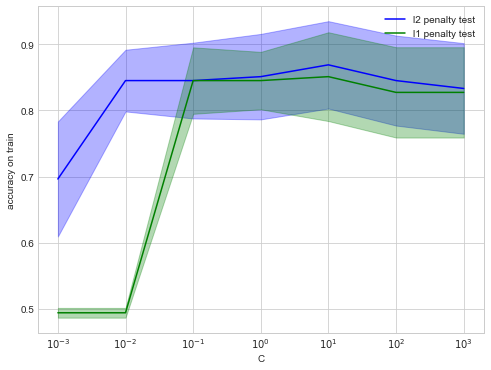

Лучшие параметры фита:  {'penalty': 'l2', 'C': 10.0}
Лучшая accuracy: 0.869047619048


In [19]:
classification_report(grid_estimator,xscale='log')

Подбираем значение С около 1

In [20]:
lr = LogisticRegression(n_jobs=-1)
search_params = {
    'penalty':['l2','l1'],
    'C':np.linspace(0.1,20,num=50)
}
cv = 5
grid_estimator_fine = GridSearchCV(estimator=lr,param_grid=search_params,cv=5,scoring='accuracy',n_jobs=1)

In [21]:
grid_estimator_fine.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  0.1    ,   0.50612,   0.91224,   1.31837,   1.72449,   2.13061,
         2.53673,   2.94286,   3.34898,   3.7551 ,   4.16122,   4.56735,
         4.97347,   5.37959,   5.78571,   6.19184,   6.59796,   7.00408,
         7.4102 ,   7.81633,   8.22245,...     17.15714,  17.56327,  17.96939,  18.37551,  18.78163,  19.18776,
        19.59388,  20.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

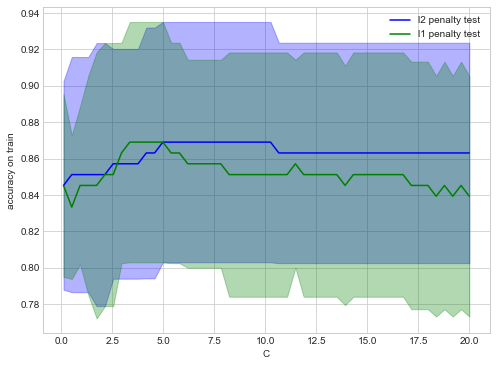

Лучшие параметры фита:  {'penalty': 'l1', 'C': 3.3489795918367347}
Лучшая accuracy: 0.869047619048


In [22]:
classification_report(grid_estimator_fine)

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
y_test_pred = grid_estimator_fine.predict(X_test)

In [25]:
print "Точность классификации логистической регрессией тестовой выборки:", accuracy_score(y_test_pred,y_test)

Точность классификации логистической регрессией тестовой выборки: 0.875


Интересно, что если классифицировать только Yulia, то точность классификации ниже - 0.86

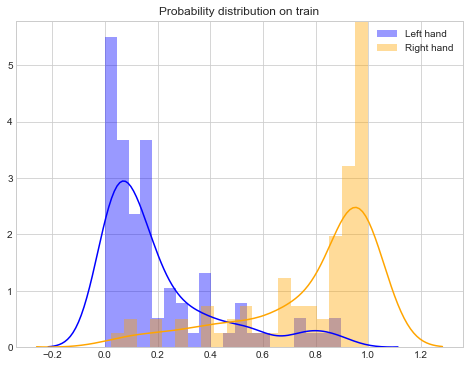

In [26]:
plt.figure(figsize=(8,6))
sns.distplot(grid_estimator_fine.predict_proba(X_train)[:,0][y_train==1.0],bins=20,color='b',label='Left hand')
sns.distplot(grid_estimator_fine.predict_proba(X_train)[:,0][y_train==0.0],bins=20,color='orange',label='Right hand')

plt.legend()
plt.title('Probability distribution on train')

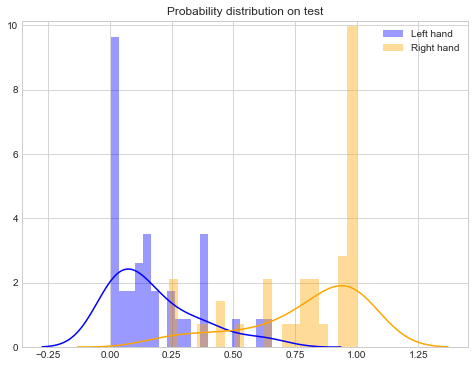

In [27]:
plt.figure(figsize=(8,6))
sns.distplot(grid_estimator_fine.predict_proba(X_test)[:,0][y_test==1.0],bins=20,color='b',label='Left hand')
sns.distplot(grid_estimator_fine.predict_proba(X_test)[:,0][y_test==0.0],bins=20,color='orange',label='Right hand')

plt.legend()
plt.title('Probability distribution on test')

Чтобы разнести вероятности можно попробовать SVM

Попробуем теперь натренировать SVM

In [68]:
from sklearn import svm

In [69]:
svm_clf = svm.NuSVC(probability=True)

In [70]:
svm_clf.fit(X_train,y_train)

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [71]:
y_pred = svm_clf.predict(X_test)

In [72]:
import sklearn.metrics as sm

In [73]:
sm.accuracy_score(y_test,y_pred)

0.88888888888888884

In [74]:
def plot_prob_distributions(pred_proba,y_true):
    plt.figure(figsize=(8,6))
    sns.distplot(pred_proba[:,0][y_true==1.0],bins=20,color='b',label='Left hand')
    sns.distplot(pred_proba[:,0][y_true==0.0],bins=20,color='orange',label='Right hand')

    plt.legend()
    plt.title('Probability distribution on test')
    plt.show()

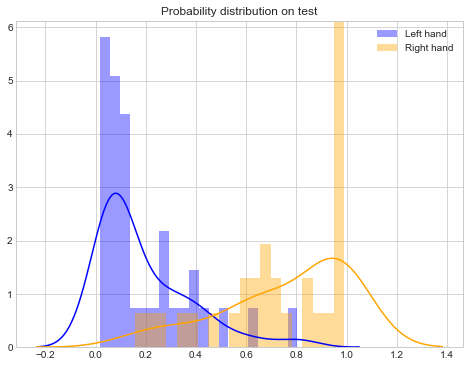

In [75]:
plot_prob_distributions(svm_clf.predict_proba(X_test),y_true=y_test)

In [76]:
svm_probas = svm_clf.predict_proba(X_test)[:,1]

In [57]:
import sklearn.calibration as calib

In [61]:
svm_probas

array([ 0.37076903,  0.90050682,  0.87066655,  0.95638029,  0.91379637,
        0.01049371,  0.035777  ,  0.73148796,  0.83182053,  0.00928613,
        0.66505133,  0.33566481,  0.88435896,  0.29818938,  0.70071836,
        0.71753767,  0.29675113,  0.94369766,  0.03615932,  0.01129863,
        0.43601949,  0.94532166,  0.01020136,  0.58959315,  0.32249182,
        0.09899282,  0.97376062,  0.01676317,  0.77371031,  0.27459288,
        0.92853997,  0.16045599,  0.55553075,  0.59316792,  0.80371784,
        0.89438602,  0.05344709,  0.1862341 ,  0.93576874,  0.37582443,
        0.02241891,  0.89591018,  0.12969138,  0.89211905,  0.27478792,
        0.91520333,  0.01501984,  0.96865685,  0.40164182,  0.87938747,
        0.04348748,  0.36935438,  0.65950865,  0.83451289,  0.21947155,
        0.04249237,  0.48338371,  0.01304032,  0.91528703,  0.01663327,
        0.97974165,  0.02587952,  0.0243044 ,  0.62708521,  0.90883308,
        0.58135882,  0.95855768,  0.7185701 ,  0.96825899,  0.53

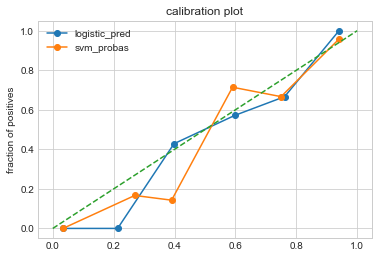

In [95]:
probs = {'svm_probas':svm_probas,'logistic_pred':logistic_pred[:,1]}

for name,prediction in probs.iteritems():

    prob_true, prob_predicted = calib.calibration_curve(y_test,prediction,normalize=True,n_bins=6)
    plt.plot(prob_predicted,prob_true,'o-',label=name)
    
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title('calibration plot')
plt.ylabel('fraction of positives')


In [65]:
logistic_pred = grid_estimator_fine.predict_proba(X_test)

В общем, я бы не сказал, что SVM в данном случае сильно смещает положение распределений.